In [173]:
import xarray as xr
import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles as cimgt
from matplotlib.patches import Patch

from shared import *
from make_rocky_beach import main

%matplotlib inline
%pdb off

print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())
# Rule: SetNull(CoNED < MLLW | (CoNED > ZT & ElNino > ZT)

Automatic pdb calling has been turned OFF
(SL)  2024-06-05 14:55:25.758300


In [169]:
region  = 'South' 
use_s2  = False
path_wd = Path(os.getenv('dataroot')) / 'Sea_Level' / 'SFEI'
print ('Region:', region)

Region: South


In [170]:
BObj = CARIRegion(region, path_wd, use_s2)
gdf_rocky_coned = BObj.get_cari('rocky')
gdf_rocky_wgs = gdf_rocky_coned.to_crs(4326)

s2_ext = '_s2' if use_s2 else ''
path_log = BObj.path_wd / f'log_{BObj.region}_rocky_pct{s2_ext}.txt'

In [171]:
basemap_d = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/Elevation/World_Hillshade_Dark/MapServer/tile/{z}/{y}/{x}.jpg')
basemap   = cimgt.GoogleTiles(url='https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg')

cxbasemap   = cx.providers.Esri.WorldImagery
cxbasemap_d = cx.providers.CartoDB.DarkMatter
cxbasemap_t = cx.providers.USGS.USTopo

projp     = ccrs.PlateCarree()

dct_proju = {'Central': ccrs.UTM(10), 'North': ccrs.UTM(10), 'South': ccrs.UTM(11)}
proju     = dct_proju[region]

TFS = 20 # title
XFS = YFS = 16 # x/y axis
GFS = 14 # deg marks
CFS = 18 # colorbar labels
pt_parms = dict(verticalalignment='top', fontsize=20, color='w',
                bbox=dict(boxstyle='square,pad=0.05', facecolor='black'))

## setup plot parms and patch label outines
sty_cari   = dict(facecolor='none', edgecolor='deeppink') 
sty_coned  = dict(facecolor='none', edgecolor='red', linestyle='--')

rect_coned = Patch(label='CoNED Tile', **sty_coned)
rect_beach = Patch(label='CARI Beach', **sty_cari)

point      = plt.Line2D([0], [0], marker='o', color='k', label='Beach', linestyle='none')
point_lost = plt.Line2D([0], [0], marker='o', color='k', label='Lost Beach', linestyle='none')

In [172]:
def buffer_poly(gser, buffx, buffy=None):
    buffy = buffx if buffy is None else buffy
    
    w, s, e, n = gser.total_bounds
    return w-buffx, s-buffy, e+buffx, n+buffy

# Check Results

## Single Test Run

In [175]:
TestObj = SetupProj(region, 'rocky', scen_test0, BObj.path_wd, use_s2)

In [176]:
scen_test0 = 'med_rsl2050'
scen_test = scen_test0.replace('_rsl', '')
da_dem_test, da_mllw0_test, da_mllw_slr_test, df_slr_test, poly_test = main(region, 'rocky', scen=scen_test0, use_s2=use_s2, test=True)

INFO:   main:118    [Jun 05, 14:57:41] 30 rocky polygons within Southern_California_Topobathy_DEM_1m_C_08

CRITICAL:   main:149    [Jun 05, 14:58:47] Southern_California_Topobathy_DEM_1m_C_08, polyix=833 cari id=80418:
CRITICAL:   compare_elevations_poly:71     [Jun 05, 14:58:55] 	82.955% ABOVE MLLW today; 77.273 in med_rsl2050. 	Lost: 5.682% 
CRITICAL:   compare_elevations_poly:71     [Jun 05, 14:59:00] 	94.886% ABOVE MAH today; 100.000 in med_rsl2050. 	Gained: 5.114% 
CRITICAL:   compare_elevations_poly:71     [Jun 05, 14:59:07] 	96.023% ABOVE MAH_ENSO today; 100.000 in med_rsl2050. 	Gained: 3.977% 


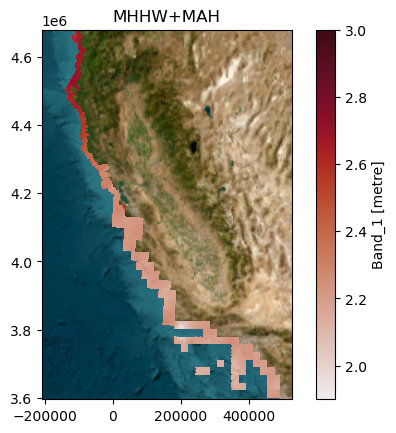

In [191]:
path_mah = BObj.path_wd / 'JPL_Share' / 'MHHW_Plus_MAH_NAVD88m_IDW.tif'
da_mah = xrr.open_rasterio(path_mah)
da_mah_re = da_mah.sel(band=1).rio.reproject(TestObj.epsg)
da_mah_re = da_mah_re.where(da_mah_re < 1e20, np.nan)
da_mah_re.rio.write_nodata(da_mah_re.rio.nodata, encoded=True, inplace=True)

qm = da_mah_re.plot(vmin=1.9, vmax=3, cmap='cmo.amp')
cx.add_basemap(ax=qm.axes, crs=da_mah_re.rio.crs, source=cxbasemap, attribution=False, zoom=5)
qm.axes.set_title('MHHW+MAH')
qm.axes.set_ylabel('')
qm.axes.set_xlabel('');

# Check No ENSO 

In [72]:
# get the enso dem file that contains this polygon
gdf_enso_map = get_enso_map(BObj.epsg) # enso dem path and its bounds
gdf_enso_map_poly = gdf_enso_map[gdf_enso_map.contains(poly_test)]
if gdf_enso_map_poly.empty:
    print (f'No ENSO dem contains polygon: {poly_test}') # add poly ix and cari id
    # continue
elif gdf_enso_map_poly.shape[0]>1:
    print (f'More than one ENSO dem contains polygon: {poly_test}, skipping for now') # add poly ix and cari id
    # continue

da_enso_dem = xrr.open_rasterio(gdf_enso_map_poly['path'].item())
da_enso_dem
# cut out the polygon

<xarray.DataArray (band: 1, y: 3000, x: 3000)> Size: 36MB
[9000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 24kB 3.405e+05 3.405e+05 ... 3.42e+05 3.42e+05
  * y            (y) float64 24kB 3.768e+06 3.768e+06 ... 3.767e+06 3.767e+06
    spatial_ref  int64 8B 0
Attributes: (12/18)
    AREA_OR_POINT:           Area
    DataType:                Generic
    LAYER_TYPE:              athematic
    SourceBandIndex:         0
    STATISTICS_COVARIANCES:  617.3098260517627
    STATISTICS_MAXIMUM:      105.04472351074
    ...                      ...
    STATISTICS_STDDEV:       24.845720477615
    _FillValue:              -3.402823e+38
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               Layer_1
    units:                   metre